<a href="https://colab.research.google.com/github/Coresight-Adithya/Automated-Projections/blob/main/Food%20and%20Bev%20Spending/Sarima%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sqlalchemy
!pip install pymysql
!pip install pmdarima

In [ ]:
from sqlalchemy import create_engine
from urllib.parse import quote
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Data from DWH
db = 'mysql+pymysql://warehouse_user:%s@partner1.coresight.com:3306/warehouse_db?charset=utf8mb4' %quote('DW@core.local')
cnx = create_engine(db).raw_connection()

dftmp = pd.read_sql_query("""
select mth, amt from dwh_uscensusretailtrade where catcode='44611'
""", con=cnx)

dftmp['ds'] = pd.to_datetime(dftmp['mth'], format='%Y-%m') + MonthEnd(1)
df = dftmp[['ds', 'amt']]
df.columns = ['ds', 'y']

cnx.close()

In [ ]:
df = df[['ds', 'y']][df['ds'] > '2010-01-01']

In [ ]:
df = df.set_index('ds')
df.index.freq = 'M'

<AxesSubplot:xlabel='ds'>

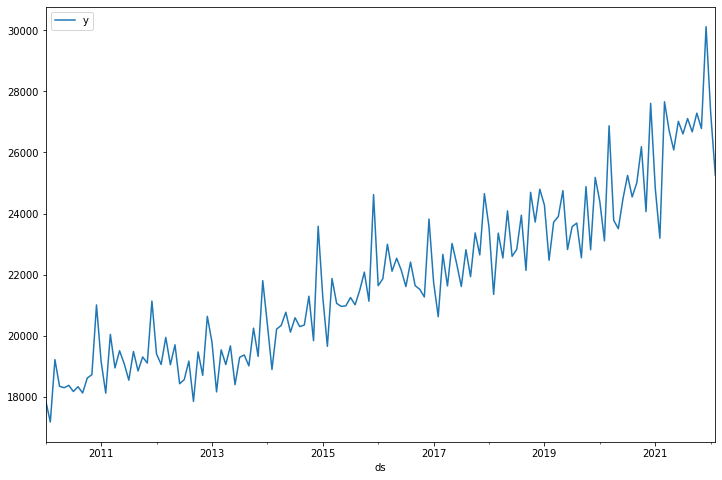

In [ ]:
df.plot(figsize=(12,8))

In [ ]:
res = seasonal_decompose(df, model='additive')

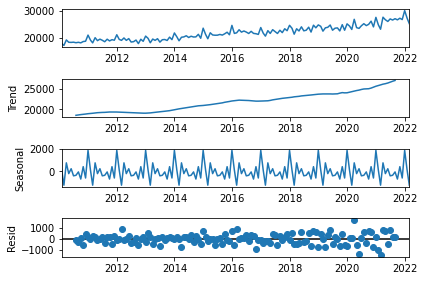

In [ ]:
res.plot();

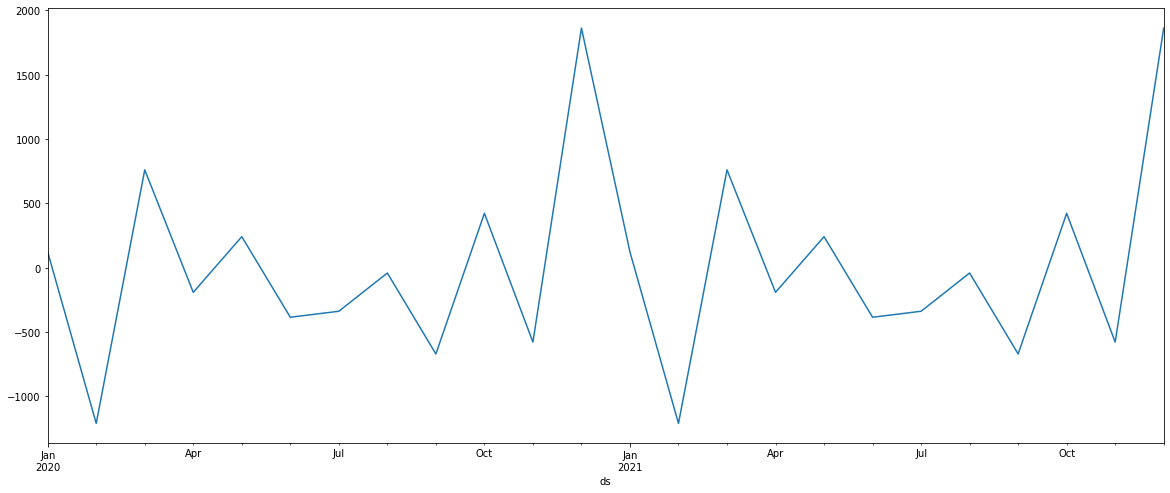

In [ ]:
res.seasonal["2020":"2021"].plot(figsize=(20,8));

In [ ]:
auto_arima(y=df, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2425.213, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2529.817, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2439.308, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2436.469, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2527.995, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2435.573, Time=0.43 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2424.005, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2468.546, Time=0.19 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2424.637, Time=1.35 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2421.663, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2469.431, Time=0.20 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2423.045, Time=0.50 sec
 ARIMA(1,1,2)(0,0,1)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  146
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1201.858
Date:                            Wed, 11 May 2022   AIC                           2415.715
Time:                                    12:42:22   BIC                           2433.576
Sample:                                         0   HQIC                          2422.973
                                            - 146                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0040      0.100    -10.087      0.000      -1.199      -0.809
ar.L2         -0.4553      0.041    -11.205      0.000      -0.535      -0.376
ma.L1          0.5956      0.113      5.284      0.000       0.375       0.816
ar.S.L12       0.9050      0.050     18.064      0.000       0.807       1.003
ma.S.L12      -0.6719      0.091     -7.390      0.000      -0.850      -0.494
sigma2      5.657e+05   6.84e+04      8.268      0.000    4.32e+05       7e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.72   Jarque-Bera (JB):                19.15
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.44
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sxorder = (2,1,1)
sxsorder = (1,0,1,12)

In [ ]:
def testmodel(train, test):
    print('train end: ', train.index[-1])
    
    print('\n---------\n')

    model = SARIMAX(endog=train, order=sxorder, seasonal_order=sxsorder).fit(disp=0)

    test['ypred'] = model.predict(start=test.index[0], end=test.index[-1])

    mape = round(np.mean(np.abs((test['y'] - test['ypred'])/test['y'])),3)
    accuracy = round((1-mape)*100,1)
    print('Accuracy: ', accuracy)

    print('\n---------\n')

    dffcast = model.get_forecast(steps=24).summary_frame()
    dffcast['bounds'] = round((pd.to_numeric(dffcast['mean_ci_upper'])-pd.to_numeric(dffcast['mean_ci_lower']))/pd.to_numeric(dffcast['mean'])*100)
    print(dffcast[['mean_ci_lower', 'mean', 'mean_ci_upper', 'bounds']])
    
    print('\n---------\n')
    
    test['mape'] = (1-round(abs(test['y'] - test['ypred'])/test['y'],6))*100
    test[['y', 'ypred', 'mape']]
    print(test[['y', 'ypred', 'mape']])

In [ ]:
testmodel(df[:-48], df[-48:])

train end:  2018-02-28 00:00:00

---------

Accuracy:  93.0

---------

y           mean_ci_lower          mean  mean_ci_upper  bounds
2018-03-31   21773.436384  23159.043004   24544.649625    12.0
2018-04-30   20592.287425  22249.657486   23907.027548    15.0
2018-05-31   21059.915546  23004.260121   24948.604696    17.0
2018-06-30   20344.648267  22556.228378   24767.808488    20.0
2018-07-31   19949.754256  22362.655615   24775.556975    22.0
2018-08-31   20151.133741  22789.758608   25428.383474    23.0
2018-09-30   19656.507646  22466.366961   25276.226277    25.0
2018-10-31   19951.483802  22955.080722   25958.677641    26.0
2018-11-30   19465.547427  22623.162930   25780.778434    28.0
2018-12-31   20619.761408  23948.296356   27276.831304    28.0
2019-01-31   19604.601092  23074.981832   26545.362572    30.0
2019-02-28   18462.838736  22087.329836   25711.820935    33.0
2019-03-31   19253.415437  23159.908344   27066.401251    34.0
2019-04-30   18471.444116  22603.761302   2673

In [ ]:
model = SARIMAX(endog=df, order=sxorder, seasonal_order=sxsorder).fit(disp=0)
pred = model.get_forecast(steps=51).summary_frame()

In [ ]:
dffin = pd.DataFrame(index=pd.date_range(df.index[0], pred.index[-1], freq='M'))

In [ ]:
dffin['y'] = df['y']
dffin['ypred'] = pred['mean']

<AxesSubplot:>

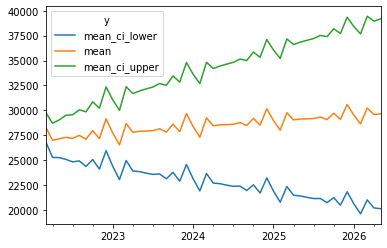

In [ ]:
pred[['mean_ci_lower', 'mean', 'mean_ci_upper']].plot()

<AxesSubplot:>

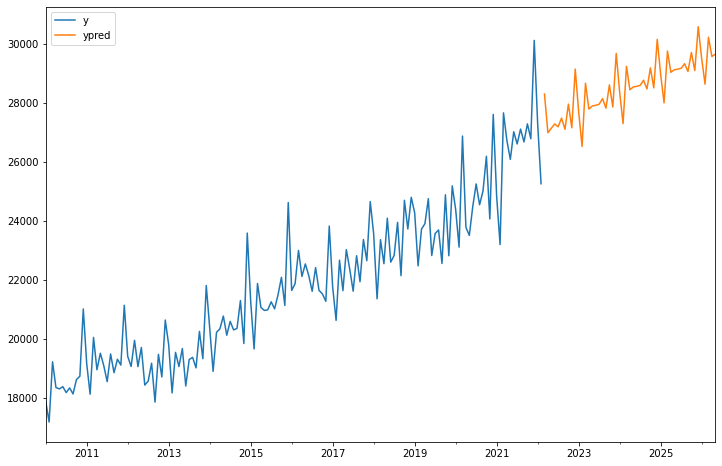

In [ ]:
dffin.plot(figsize=(12,8))

In [ ]:
pred

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-03-31,28298.310030,752.168592,26824.086679,29772.533381
2022-04-30,26988.427903,873.917302,25275.581466,28701.274340
2022-05-31,27140.333086,965.712108,25247.572136,29033.094037
2022-06-30,27284.805536,1129.062458,25071.883782,29497.727289
2022-07-31,27189.046484,1206.655671,24824.044827,29554.048142
2022-08-31,27483.304942,1308.597458,24918.501053,30048.108831
2022-09-30,27103.003230,1400.118136,24358.822110,29847.184350
2022-10-31,27957.907249,1476.797700,25063.436943,30852.377554
2022-11-30,27155.236840,1559.745124,24098.192572,30212.281107
2022-12-31,29147.444653,1632.639915,25947.529220,32347.360086


In [ ]:
pred = pred[['mean', 'mean_ci_lower', 'mean_ci_upper']]
pred.columns = ['Projection', 'Lower Bound', 'Upper Bound']
pred.to_excel('Drugstore Projected MarketSize - USCensus.xlsx')